In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipaddress
import geoip2.database
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.cm as cm
%matplotlib inline

Load data

In [2]:
df = pd.read_csv('../data/unique_van_rtp_pairings.csv')
df.head()

,Unnamed: 0,Unnamed: 1,a_saddr_asn,a_saddr_asorg,a_saddr_lat,a_saddr_long,b_saddr_asn,b_saddr_asorg,b_saddr_lat,b_saddr_long
0,71483861,2018-03-15,395152,CloudPBX,43.6319,-79.3716,5607,Sky UK Limited,53.2738,-2.6087
1,65221709,2018-01-11,395152,CloudPBX,43.6319,-79.3716,3356,"Level 3 Parent, LLC",37.7510,-97.8220
2,64743723,2018-01-04,395152,CloudPBX,43.6319,-79.3716,32308,"8x8, Inc.",37.7510,-97.8220
3,65528895,2018-01-15,395152,CloudPBX,43.6319,-79.3716,16504,Granite Telecommunications LLC,37.7510,-97.8220
4,78144650,2018-05-23,395152,CloudPBX,43.6319,-79.3716,7018,"AT&T Services, Inc.",37.7510,-97.8220


In [3]:
DATA_ROOT = '../data'
GEOLITE_DB_PATH = os.path.join(DATA_ROOT,'GeoLite2-City.mmdb')

Convert ip to coordinates or load coordinates if already available

In [4]:
def findLat(ip):
    try: return reader.city(ip).location.latitude
    except ValueError: return np.nan

def findLon(ip):
    try: return reader.city(ip).location.longitude
    except ValueError: return np.nan

In [5]:
lata = df['a_saddr_lat']
lona = df['a_saddr_long']
latb = df['b_saddr_lat']
lonb = df['b_saddr_long']

Finding unique ASN names - as list

In [6]:
orga = df['a_saddr_asorg']
orgb = df['b_saddr_asorg']
unique_ogsb = orgb.unique()
unique_ogsa = orga.unique()

In [7]:
def make_dictionary_colors(unique_ogsb):
    ''' 1. Makes a list of colours
        2. Assigns a unique colour to a unique ASN
    '''
    cm_times = np.linspace(0, 1, len(unique_ogsb))
    colors = [cm.rainbow(x) for x in cm_times]

    dictionary = {}
    for i in range(len(unique_ogsb)):
        dictionary[unique_ogsb[i]] = colors[i]
        
    return dictionary

def make_map(ll_lat, ll_lon, ur_lat, ur_lon, parallels):
    ''' Plots the basic map using:
    lower left lat
    lower left lon
    upper right lat
    upper right lon
    and intervals for drawing the map parallels
    '''
    
    fig = plt.figure(figsize=(20, 16), edgecolor='w')
    m = Basemap(projection='cyl', resolution='h', llcrnrlat=ll_lat, llcrnrlon=ll_lon, urcrnrlat=ur_lat, urcrnrlon=ur_lon)
    m.drawparallels(np.arange(-90.,91.,parallels),labels=[True,False,True,False])
    m.drawmeridians(np.arange(-180.,181.,parallels),labels=[False,True,True,False])
    m.drawcoastlines()
    m.fillcontinents(color='w')
    m.drawstates()
    m.drawcountries()
    m.shadedrelief()
    return fig, m

# Wider Map

In [8]:
ll_lat, ll_lon, ur_lat, ur_lon = 22, -130, 65, -55

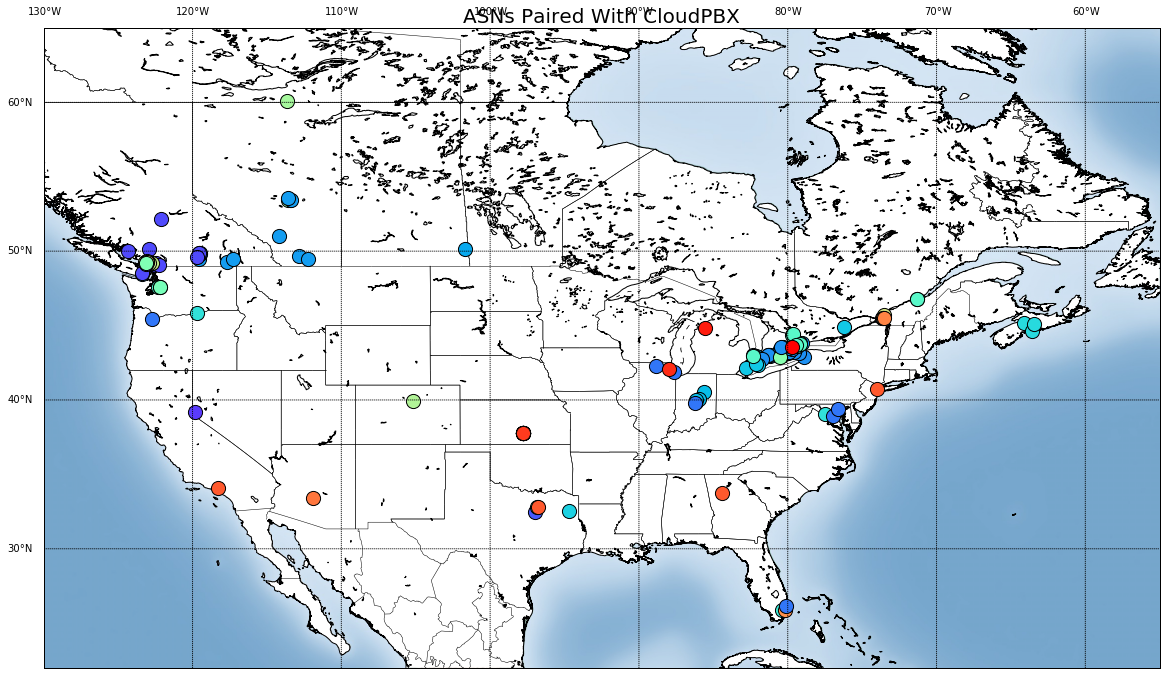

In [9]:
fig, m = make_map(ll_lat, ll_lon, ur_lat, ur_lon, 10)

dictionary = make_dictionary_colors(unique_ogsb)

xa, ya = m(lona, lata)

for i in range(len(latb)):
    orgb_name = orgb[i]
    c = dictionary[orgb_name]
    xb, yb = m(lonb[i], latb[i])
    m.scatter(xb, yb, marker='o', c=c, alpha=1, s=200, zorder=2, label=orgb_name)
    
#plt.legend()
plt.title('ASNs Paired With CloudPBX', fontsize=20)

plt.show()
fig.savefig('ASN_NorthAmerica.png', dpi=100, bbox_inches='tight')

# Vancouver

Narrowing down which ASN's have IP's within the map plot domain

In [10]:
ll_lat, ll_lon, ur_lat, ur_lon = 48.6, -123.8, 49.8, -122.2

lat_limits_inds = np.where((latb <= ur_lat) & (latb >= ll_lat))[0]

lon_limits_inds = np.where((lonb <= ur_lon) & (lonb >= ll_lon))[0]

domain_inds = list(set(lat_limits_inds).intersection(lon_limits_inds))

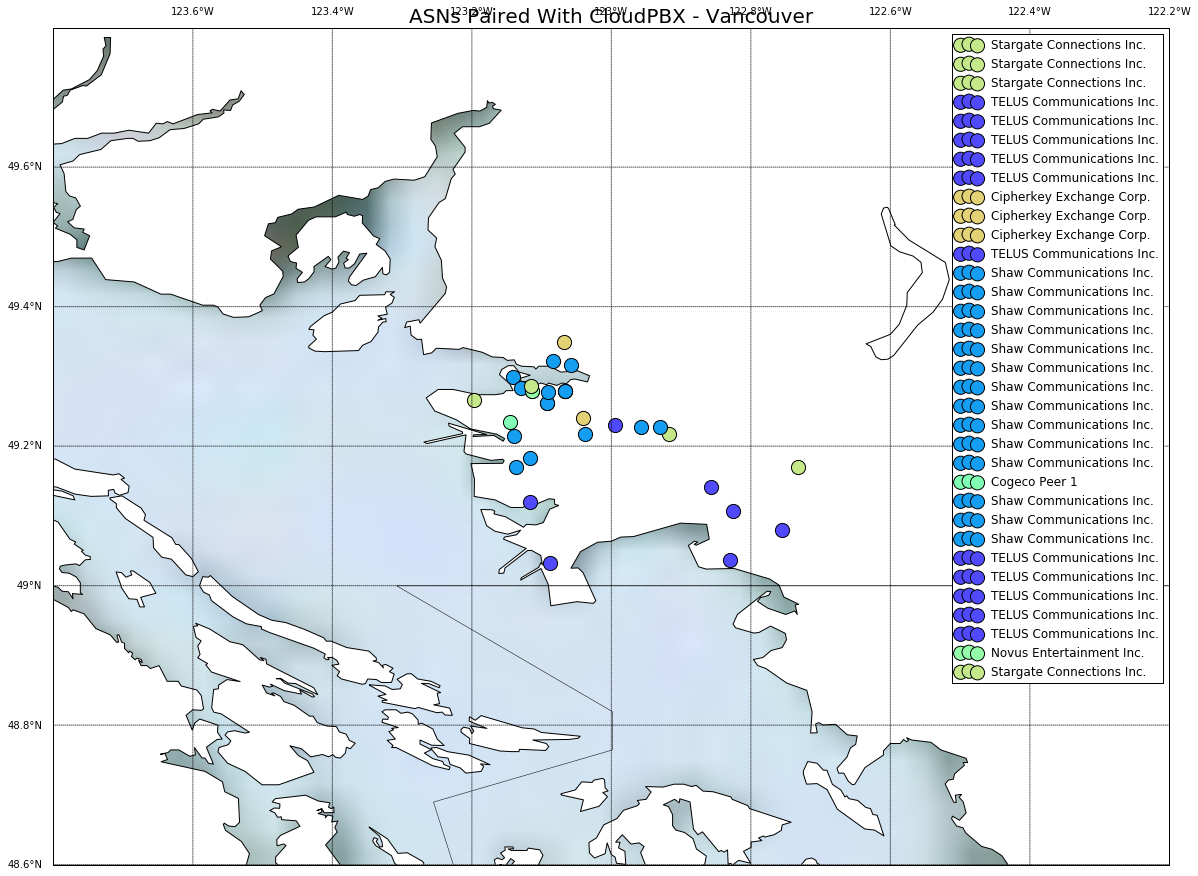

In [11]:
fig, m = make_map(ll_lat, ll_lon, ur_lat, ur_lon, 0.2)

dictionary = make_dictionary_colors(unique_ogsb)

xa, ya = m(lona, lata)

for i in domain_inds:
    orgb_name = orgb[i]
    c = dictionary[orgb_name]
    xb, yb = m(lonb[i], latb[i])
    m.scatter(xb, yb, marker='o', c=c, alpha=1, s=200, zorder=2, label=orgb_name)
    
plt.legend()
plt.title('ASNs Paired With CloudPBX - Vancouver', fontsize=20)

plt.show()
fig.savefig('ASN_Vancouver.png', dpi=100, bbox_inches='tight')